# Cross-resonance gate between a transmon and a fluxonium: leakage analysis

In this notebook we study leakage in the cross-resonance two-qubit gate between a transmon and a fluxonium. 

In [1]:
import numpy as np
import scipy.integrate
import time
import qutip as qtp
import matplotlib.pyplot as plt
from scipy.optimize import minimize
import pysqkit
from pysqkit import QubitSystem
from pysqkit.drives.pulse_shapes import gaussian_top
from pysqkit.util.metrics import average_process_fidelity, \
    average_gate_fidelity
from pysqkit.util.phys import temperature_to_thermalenergy
from pysqkit.util.quantum import generalized_rabi_frequency
import pysqkit.util.transformations as trf
from pysqkit.util.linalg import get_mat_elem
from pysqkit.solvers.solvkit import integrate
from pysqkit.util.hsbasis import weyl_by_index
from pysqkit.solvers import solvkit
from pysqkit.drives.pulse_shapes import gaussian_top
import qutip
from typing import List, Dict, Callable
import matplotlib
matplotlib.rcParams['mathtext.fontset'] = 'cm'
import util_cr as util
import copy
import json
import cmath

from IPython.display import display, Latex

# Introducing the qubits and the coupled system

In [2]:
with open('../flx_transm_params.txt') as param_file:
    parameters_set = json.load(param_file)

In [3]:
temperature = 0.000 #0.020 # K
thermal_energy = temperature_to_thermalenergy(temperature) # kb T/h in GHz
d_comp = 4

p_set = "CR_3"


#Transmon
levels_t = 3
transm = pysqkit.qubits.SimpleTransmon(
    label='T', 
    max_freq= 5.2, #parameters_set[p_set]["max_freq_t"], 
    anharm=parameters_set[p_set]["anharm_t"],
    diel_loss_tan=parameters_set[p_set]["diel_loss_tan_t"], #set to zero to check d_1 L1 = d_2 L2
    env_thermal_energy=thermal_energy,    
    dim_hilbert=levels_t,
    dephasing_times=None #parameters_set[p_set]["dephasing_times_t"]
)

#Fluxonium
levels_f = 5

flx = pysqkit.qubits.Fluxonium(
    label='F', 
    charge_energy=parameters_set[p_set]["charge_energy_f"], 
    induct_energy=parameters_set[p_set]["induct_energy_f"], 
    joseph_energy=parameters_set[p_set]["joseph_energy_f"], #8.0, 
    diel_loss_tan=parameters_set[p_set]["diel_loss_tan_f"], #set to zero to check d_1 L1 = d_2 L2
    env_thermal_energy=thermal_energy,
    dephasing_times=None #parameters_set[p_set]["dephasing_times_f"] #ns/2*np.pi 
)
flx.diagonalize_basis(levels_f)

# We also add a drive on the fluxonium
flx.add_drive(
    pysqkit.drives.microwave_drive,
    label='cr_drive_f',
    pulse=pysqkit.drives.pulses.cos_modulation,
    pulse_shape=pysqkit.drives.pulse_shapes.gaussian_top
)

d_leak = levels_t*levels_f - d_comp

jc = parameters_set[p_set]["jc"]
coupled_sys = transm.couple_to(flx, coupling=pysqkit.couplers.capacitive_coupling, strength=jc)
bare_system = transm.couple_to(flx, coupling=pysqkit.couplers.capacitive_coupling, strength=0.0)

states_label = coupled_sys.all_state_labels()
states_dict = coupled_sys.states_as_dict(as_qobj=True)
flx_freq = flx.eig_energies(2)[1] - flx.eig_energies(2)[0]
flx_freq_03 = flx.eig_energies(4)[3] - flx.eig_energies(4)[0]
flx_freq_12 = flx.eig_energies(4)[2] - flx.eig_energies(4)[1]
# flx_freq_04 = flx.eig_energies(5)[4] - flx.eig_energies(4)[0]
# flx_freq_05 = flx.eig_energies(6)[5] - flx.eig_energies(6)[0]

In [4]:
state_label = ["00", "01", "10", "11"]
comp_states = {}
for label in state_label:
    state_tmp = coupled_sys.state(label)[1]
    loc = np.argmax(np.abs(state_tmp))
    phase = cmath.phase(state_tmp[loc])
    state_tmp = np.exp(-1j*phase)*state_tmp
    comp_states[label] = state_tmp

ValueError: label specifies level 5 for qubit F, but qubit is 5-dimensional

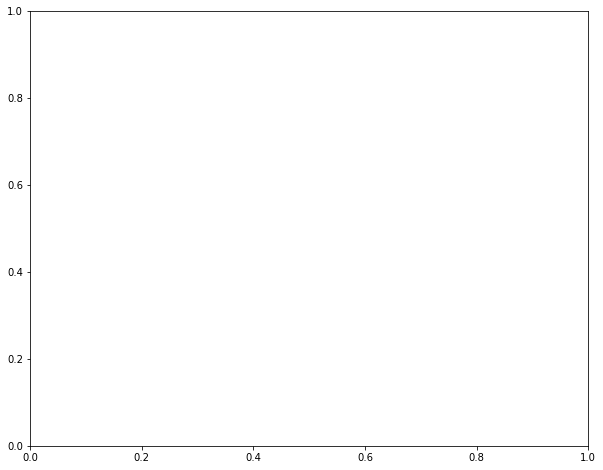

In [5]:
level_list = ['00', '01', '10', '11', '02', '20', '12','21', '03', '13', '04', '05', '15', '22', '23', '14']

util.energy_levels_diagram(bare_system, level_list, show_drive=False)

In [6]:
def mu_yz_flx(comp_states, op) -> float:
    yz0 = get_mat_elem(op, comp_states['00'], comp_states['10'])
    yz1 = get_mat_elem(op, comp_states['01'], comp_states['11'] )
    return (np.imag(yz0 - yz1))/2

def mu_zy_transm(comp_states, op) -> float:
    yz0 = get_mat_elem(op, comp_states['00'], comp_states['01'])
    yz1 = get_mat_elem(op, comp_states['10'], comp_states['11'] )
    return (np.imag(yz0 - yz1))/2

def mu_yi_flx(comp_states, op) -> float:
    yz0 = get_mat_elem(op, comp_states['00'], comp_states['10'] )
    yz1 = get_mat_elem(op, comp_states['01'], comp_states['11'] )
    return (np.imag(yz0 + yz1))/2

In [7]:
display(Latex(r'$f_{{flx}} = {:.3f} \, \mathrm{{MHz}}$'.format(flx_freq*1e3)))
display(Latex(r'$\xi_{{ZZ}}/h = {:.3f} \, \mathrm{{MHz}}$'.format(1e3*util.zz(coupled_sys))))
q_op = coupled_sys["F"].charge_op()
display(Latex(r'$\mu_{{YZ}} = {:.4f} $'.format(mu_yz_flx(comp_states, q_op))))
display(Latex(r'$\mu_{{YI}} = {:.4f} $'.format(mu_yi_flx(comp_states, q_op))))
display(Latex(r'$\mu_{{ZY}} = {:.6f} $'.format(mu_zy_transm(comp_states, q_op))))

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

In [8]:
def func_to_minimize(
    pulse_time: list,
    t_rise: float,
    eps: float
) -> float:
    step = 1e-3
    n_points = int(pulse_time[0]/step)
    times = np.linspace(0, pulse_time[0], n_points)
    pulse = gaussian_top(times, t_rise, pulse_time[0])
    integral = scipy.integrate.simpson(2*np.pi*eps*pulse, times)
    return np.abs(integral - np.pi/4)  #Watch out factor of 2?  
    

In [9]:
eps_drive = 0.62 #GHz
op = coupled_sys["F"].charge_op()*eps_drive
freq_drive = transm.max_freq
omega_drive = np.abs(get_mat_elem(op, coupled_sys.state("01")[1], coupled_sys.state("11")[1]))
delta_drive = freq_drive - transm.max_freq
rabi_period = 1/np.sqrt(omega_drive**2 + delta_drive**2)
t_rise = 10.0 # [ns]

t_tot_0 = [100.0]

args_to_pass = (t_rise, np.abs(mu_yz_flx(comp_states, q_op))*eps_drive/2) #factor of two seems right here

# We find the total time to obtain the desired gate

start = time.time()

minimization_result = minimize(func_to_minimize, t_tot_0, args=args_to_pass)

print(minimization_result)

end = time.time()

t_tot = minimization_result['x'][0] #1/(util.y_z_flx(coupled_sys, 'F')*eps_drive*4)  # [ns]
print("t_tot: {} ns".format(t_tot))
pts_per_drive_period = 10

#t_tot = 135

nb_points = int(t_tot*freq_drive*pts_per_drive_period)
tlist = np.linspace(0, t_tot, nb_points)

coupled_sys['F'].drives['cr_drive_f'].set_params(phase=0, time=tlist, rise_time=t_rise, pulse_time=t_tot,
                                                 amp=eps_drive, freq=freq_drive)


      fun: 3.7563174792865084e-11
 hess_inv: array([[1.46934773e-06]])
      jac: array([2.90125608e-05])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 101
      nit: 2
     njev: 45
   status: 2
  success: False
        x: array([165.46969349])
t_tot: 165.4696934877826 ns


In [10]:
simu_opt = qtp.solver.Options()
simu_opt.atol = 1e-12
simu_opt.rtol = 1e-10

env_syst = pysqkit.tomography.TomoEnv(system=coupled_sys, time=2*np.pi*tlist, options=simu_opt, 
                                      with_noise=True, dressed_noise=True)

In [11]:
comp_states_list = []
for key in comp_states.keys():
    comp_states_list.append(comp_states[key])

In [12]:
coupled_sys.diagonalizing_unitary(as_qobj=True)

Quantum object: dims = [[3, 5], [3, 5]], shape = (15, 15), type = oper, isherm = True
Qobj data =
[[ 9.99999605e-01  0.00000000e+00  2.20621155e-06  0.00000000e+00
   7.62111784e-06  0.00000000e+00  5.73894481e-04  0.00000000e+00
   6.78682279e-04  0.00000000e+00 -4.97964743e-06  0.00000000e+00
   4.26514013e-06  0.00000000e+00  1.37711802e-06]
 [ 8.25077853e-17 -9.99998652e-01  6.02816408e-17 -1.23989215e-05
   5.84601811e-16  7.18451348e-04  0.00000000e+00 -1.44318805e-03
   0.00000000e+00  3.11721286e-04 -3.46944695e-17  1.38618446e-05
   1.90819582e-17 -2.86697643e-06  4.33680869e-18]
 [ 5.36359298e-07 -5.24604881e-17  9.99975066e-01  1.40364060e-16
   2.51220313e-05  9.65297125e-16 -6.84269309e-03 -2.29026021e-17
   1.74474649e-03 -1.43167793e-18 -1.71797605e-05  3.11420122e-19
   1.39040630e-05 -2.49176308e-19  2.42109566e-06]
 [-1.63684775e-17 -1.34161578e-06 -1.52611882e-16  9.99966873e-01
   4.91164508e-16  5.81457304e-03 -9.01123773e-18 -5.24571673e-03
  -6.39650682e-18 -2.21

In [13]:
coupled_sys.state("12")

(11.326612255753513,
 array([ 0.00000000e+00+0.j, -1.44318805e-03+0.j, -2.29026021e-17+0.j,
        -5.24571673e-03+0.j, -1.81249916e-15+0.j,  1.57541143e-05+0.j,
        -1.21864324e-16+0.j,  9.99914666e-01+0.j, -1.39428399e-16+0.j,
        -1.66227725e-05+0.j, -2.17062226e-15+0.j, -1.15963450e-02+0.j,
         1.62330218e-18+0.j, -2.56615560e-03+0.j, -4.24823206e-18+0.j]))

In [14]:
avg_leakage = env_syst.leakage(comp_states_list)
display(Latex(r'$L_1(\mathcal{{E}} ) = {:.7f}$'.format(avg_leakage)))

<IPython.core.display.Latex object>

In [49]:
avg_seepage = env_syst.seepage(comp_states_list)
display(Latex(r'$L_2(\mathcal{{E}} ) = {:.7f}$'.format(avg_seepage)))

<IPython.core.display.Latex object>

In [50]:
display(Latex(r'$d_1 L_1(\mathcal{{E}} ) = {:.7f}$'.format(d_comp*avg_leakage)))

<IPython.core.display.Latex object>

In [51]:
display(Latex(r'$d_2 L_2(\mathcal{{E}} ) = {:.7f}$'.format(d_leak*avg_seepage)))

<IPython.core.display.Latex object>

# Leakage analysis

To study leakage we consider the noiseless case

In [27]:
def run(
    time: np.ndarray,
    system: QubitSystem, 
    state_init: qtp.qobj.Qobj, 
    options: qtp.solver.Options=None,
    with_noise: bool=False
):
    hamil0 = system.hamiltonian(as_qobj=True)
    hamil_drive = []
    pulse_drive = []
                    
    for qubit in system:
        if qubit.is_driven:
            for label, drive in qubit.drives.items():
                hamil_drive.append(drive.hamiltonian(as_qobj=True))
                pulse_drive.append(drive.eval_pulse())
    if with_noise:
        jump_op = [op for qubit in system for op in qubit.collapse_ops(as_qobj=True)]
    else:
        jump_op = []
                    
    result = integrate(time, state_init, hamil0, hamil_drive,
                           pulse_drive, jump_op, "mesolve", options=options)
                    
    return result  

In [32]:
start = time.time()

_proj_comp = np.einsum('ai, aj -> ij', comp_states_list, np.conj(comp_states_list))
subsys_dims = list(q.dim_hilbert for q in coupled_sys)
proj_comp = qtp.Qobj(inpt=_proj_comp, dims=[subsys_dims, subsys_dims], isherm=True)
res = run(time=2*np.pi*tlist, system=coupled_sys, state_init=proj_comp/d_comp, 
          options=simu_opt, with_noise=True)

end=time.time()
display(Latex(r'$\mathrm{{Leakage \, computation \, time}} = {:.3f} \, s$'.format(end - start)))
l1 = 1 - qtp.expect(proj_comp, res.states[-1])

<IPython.core.display.Latex object>

In [33]:
comp_state_label = ['00', '01', '10', '11']
leakage_states = []
for lev_t in range(0, levels_t):
    for lev_f in range(0, levels_f):
        if str(lev_t) + str(lev_f) not in comp_state_label:
            leakage_states.append(str(lev_t) + str(lev_f))

In [34]:
def get_probabilities(
    states_label: List[str], 
    system:QubitSystem, 
    final_state: qtp.qobj.Qobj
) -> Dict:
    prob = {}
    for label in states_label:
        ket = system.state(label, as_qobj=True)[1]
        projector = ket*ket.dag()
        prob[label] = qtp.expect(projector, final_state)
    return prob

In [35]:
leak_probs = get_probabilities(leakage_states, coupled_sys, res.states[-1])

display(Latex(r'$\mathrm{{Average\, Leakage \,}} L_1 = {:.7f} $'.format(l1)))

sum_leak = 0

for label in leakage_states:
    display(Latex(r'$P_{{leak, {}  }} = {:.7f}$'.format(label, leak_probs[label])))
    sum_leak += leak_probs[label]
display(Latex(r'$\sum_k P_{{leak, k  }} = {:.7f}$'.format(sum_leak)))

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>